# Load and explore the data

In [1]:
from datasets import load_dataset
## dataset link: https://huggingface.co/datasets/dair-ai/emotion

dataset = load_dataset("dair-ai/emotion")

c:\Users\raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Label Meaning as mentioned on the huggingface documentation: 
## sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).
dataset['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [3]:
# Length of train and test dataset
print(f"Train size: {len(dataset['train'])}, test size: {len(dataset['test'])}")
print(f"longets sequence: {max(len(x) for x in dataset['train']['text'])}")

Train size: 16000, test size: 2000
longets sequence: 300


## Build vocabulary

In [4]:
import regex as re

## Explaining GPT4 tokenization pattern
## ?i: case insensitive matching. This is applied on the first group of the pattern (?i:[sdmt]|ll|ve|re)
## [sdmt] matches any of the characters s, d, m, or t (this will cover 's, 'd, 'm, and 't which were explicitly mentioned in gpt2 pattern)
## |ll|ve|re matches ll, ve, or re (this will cover 'll, 've, and 're)
## [^\r\n\p{L}\p{N}]?+\p{L}+ matches any non-space, non-letter, non-digit character,(special characters like @, #) followed by one or more letters
##      -> ^ is used for negation, so [^\r\n\p{L}\p{N}] means any character that is not a newline, letter, or digit
##      -> \r and \n are carriage return and newline characters, \p{L} is any letter, and \p{N} is any digit
##      -> ?+ is a non-greedy match for the previous character, so [^\r\n\p{L}\p{N}]?+ matches zero or one of the previous character
##      -> \p{L}+ matches one or more letters

## I don't understand the difference between ? and ?+ (used here: [^\r\n\p{L}\p{N}]?+)

## \p{N}{1,3} matches one to three digits
## ?[^\s\p{L}\p{N}]++[\r\n]* matches any non-space, non-letter, non-digit character, followed by zero or more of the same type of character, followed by zero or more newlines
##      -> [^\s\p{L}\p{N}]++ matches one or more non-space, non-letter, non-digit characters
##      -> \s matches any whitespace character
##      -> [\r\n]* matches zero or more newlines

## Again I don't understand ++ used in [^\s\p{L}\p{N}]++ We could've ust used single +

## \s*[\r\n] matches zero or more whitespace characters followed by a newline
## \s+(?!\S) matches one or more whitespace characters that are not followed by a non-whitespace character
## \s+ matches one or more whitespace characters





GPT4_TOKN_PAT = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""
compiled_pat = re.compile(GPT4_TOKN_PAT)

print(f"Original: {dataset['train'][0]['text']}")
print(f"Tokenized: {compiled_pat.findall(dataset['train'][0]['text'])}")

Original: i didnt feel humiliated
Tokenized: ['i', ' didnt', ' feel', ' humiliated']


In [5]:
## I Used to do text.lower() and whitespace removal before tokenization. 
## Now I feel like it's better to keep the original text as it is and then tokenize it.
## Reason being is that, a ssimple "wow" and "WOW" can have different emotions while texting.
## And also, the way a user it typying their response can also be a feature to consider. SO, whitespaces are also important.

vocab = set()
for example_idx in range(len(dataset['train'])):
    for token in re.findall(compiled_pat, dataset['train'][example_idx]['text']): 
        vocab.add(token)

## Adding a special token for out of vocabulary words
## Also add padding token

vocab.add("<unk>")
vocab.add("<pad>")
vocab = sorted(vocab)
vocab_size = len(vocab)

In [6]:
print(f"Vocab size: {len(vocab)}")
print(vocab[:10])

Vocab size: 15269
[' a', ' aa', ' aaaaaaand', ' aaaaand', ' aaaand', ' aac', ' aahhh', ' aaron', ' ab', ' abandon']


In [7]:
token_idx_map = {token: idx for idx, token in enumerate(vocab)}

# Building a simple RNN model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
nn.Embedding?

Init signature:
nn.Embedding(
    num_embeddings: int,
    embedding_dim: int,
    padding_idx: Optional[int] = None,
    max_norm: Optional[float] = None,
    norm_type: float = 2.0,
    scale_grad_by_freq: bool = False,
    sparse: bool = False,
    _weight: Optional[torch.Tensor] = None,
    _freeze: bool = False,
    device=None,
    dtype=None,
) -> None
Docstring:     
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices.
The input to the module is a list of indices, and the output is the corresponding
word embeddings.

Args:
    num_embeddings (int): size of the dictionary of embeddings
    embedding_dim (int): the size of each embedding vector
    padding_idx (int, optional): If specified, the entries at :attr:`padding_idx` do not contribute to the gradient;
                                 therefore, the embedding vector at :attr:`padding_idx` is not updated during train

In [10]:
nn.RNN?

Init signature: nn.RNN(*args, **kwargs)
Docstring:     
__init__(self,input_size,hidden_size,num_layers=1,nonlinearity='tanh',bias=True,batch_first=False,dropout=0.0,bidirectional=False,device=None,dtype=None)

Applies a multi-layer Elman RNN with :math:`\tanh` or :math:`\text{ReLU}` non-linearity to an
input sequence.

For each element in the input sequence, each layer computes the following
function:

.. math::
    h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})

where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is
the input at time `t`, and :math:`h_{(t-1)}` is the hidden state of the
previous layer at time `t-1` or the initial hidden state at time `0`.
If :attr:`nonlinearity` is ``'relu'``, then :math:`\text{ReLU}` is used instead of :math:`\tanh`.

Args:
    input_size: The number of expected features in the input `x`
    hidden_size: The number of features in the hidden state `h`
    num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``

In [11]:
## I want to define these hyperparameters:
## 1. Embedding dimension 
## 2. Hidden dimension
## 3. Output dimension
## 4. Learning rate
## 5. Number of epochs
## 6. Batch size
## 7. Number of layers in the RNN
## 8. Dropout rate

EMBD_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 6
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 512
NUM_LAYERS = 2
DROP_RATE = 0.5

## Design the classifier model

class Classifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        
        ## Input shape = Batch, seq_len
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim, padding_idx=token_idx_map["<pad>"], )
        ## Shape = Batch, seq_len, embed_dim
        self.rnn = nn.RNN(input_size = embed_dim, hidden_size = hidden_dim, num_layers = NUM_LAYERS, batch_first=True)
        ## Shape = Batch, seq_len, hidden_dim
        self.dropout = nn.Dropout(DROP_RATE)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embed(x)
        output, hidden = self.rnn(embedded)
        output = self.dropout(output)
        return self.fc(hidden[-1]) ## If we were using only 1 layer, then we could've used hidden.squeeze(0) instead of hidden[-1]

## Defining the loss function
criterion = nn.CrossEntropyLoss()

model = Classifier(vocab_size = vocab_size, embed_dim = EMBD_DIM, hidden_dim = HIDDEN_DIM, output_dim = OUTPUT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
        

In [12]:
print("Model Layers:\n===================\n")

for name, param in model.named_parameters():
    print(f"Layer '{name}': {param.shape}")

print("\nTotal Parameters:", sum(param.numel() for param in model.parameters()))

Model Layers:

Layer 'embed.weight': torch.Size([15269, 100])
Layer 'rnn.weight_ih_l0': torch.Size([256, 100])
Layer 'rnn.weight_hh_l0': torch.Size([256, 256])
Layer 'rnn.bias_ih_l0': torch.Size([256])
Layer 'rnn.bias_hh_l0': torch.Size([256])
Layer 'rnn.weight_ih_l1': torch.Size([256, 256])
Layer 'rnn.weight_hh_l1': torch.Size([256, 256])
Layer 'rnn.bias_ih_l1': torch.Size([256])
Layer 'rnn.bias_hh_l1': torch.Size([256])
Layer 'fc.weight': torch.Size([6, 256])
Layer 'fc.bias': torch.Size([6])

Total Parameters: 1751674


In [13]:
# batch = dataset['train'][0:32]

# for example_text in batch['text']:
#     print(example_text)
#     print(compiled_pat.findall(example_text))
#     print([token_idx_map[token] for token in compiled_pat.findall(example_text)])
#     break

# text = [re.findall(compiled_pat, example_text) for example_text in batch['text']]
# [[token_idx_map[token] for token in example] for example in text]



In [14]:
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [15]:
## Training loop

def train(model, dataset, optimizer, criterion, batch_size, num_epochs):
    
    losses = []

    for epoch in range(num_epochs):
        dataset = dataset.shuffle()
        for batch_idx in range(0, len(dataset), batch_size):
            
            ## Forward Pass
            batch = dataset[batch_idx: batch_idx + batch_size]
            text = [re.findall(compiled_pat, example_text) for example_text in batch['text']]
            text = [[token_idx_map[token] if token in token_idx_map else token_idx_map["<unk>"] for token in example] for example in text]
            
            # Pad sequences
            text = pad_sequence([torch.tensor(example) for example in text], batch_first=True, padding_value=token_idx_map["<pad>"])

            labels = torch.tensor([example_label for example_label in batch['label']])
            ## Backward Pass
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f"Epoch: {epoch}, Loss: {loss.item()}")
    
    plt.plot(losses)

Epoch: 0, Loss: 1.602522611618042
Epoch: 1, Loss: 1.500941276550293
Epoch: 2, Loss: 1.6175740957260132
Epoch: 3, Loss: 1.6452038288116455
Epoch: 4, Loss: 1.6401638984680176
Epoch: 5, Loss: 1.5183303356170654
Epoch: 6, Loss: 1.5534172058105469
Epoch: 7, Loss: 1.5946800708770752
Epoch: 8, Loss: 1.618638277053833
Epoch: 9, Loss: 1.5210343599319458


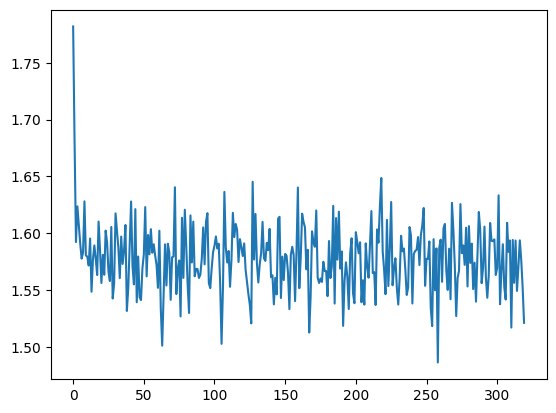

In [16]:
train(model, dataset['train'], optimizer, criterion, BATCH_SIZE, EPOCHS)

In [17]:
## Testing the model
# text, label = dataset['test'][0]['text'], dataset['test'][0]['label']

# text = [token_idx_map[token] if token in token_idx_map else token_idx_map["<unk>"] for token in re.findall(compiled_pat, text)]
# text = torch.tensor(text).unsqueeze(0)
# output = model(text)
# output = F.softmax(output, dim=1)
# output = torch.argmax(output)
# output, label

In [18]:
from sklearn.metrics import f1_score

def test(model, dataset, verbose=False):
    predictions = []
    true_labels = []
    
    for batch_idx in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[batch_idx: batch_idx + BATCH_SIZE]
        text = [re.findall(compiled_pat, example_text) for example_text in batch['text']]
        text = [[token_idx_map[token] if token in token_idx_map else token_idx_map["<unk>"] for token in example] for example in text]
        text = pad_sequence([torch.tensor(example) for example in text], batch_first=True, padding_value=token_idx_map["<pad>"])
        labels = torch.tensor([example_label for example_label in batch['label']])
        output = model(text)
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        
        predictions.extend(output.tolist())
        true_labels.extend(labels.tolist())
    
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    if verbose:
        print(f"F1 Score: {f1}")
    
    return f1


In [20]:
train_f1 = test(model, dataset['train'])
val_f1 = test(model, dataset['validation'])
test_f1 = test(model, dataset['test'])

print(f"Train F1: {train_f1}, Validation F1: {val_f1}, Test F1: {test_f1}")

Train F1: 0.17150439865990486, Validation F1: 0.184297235782734, Test F1: 0.18241438101732171


# Using Bi Directional LSTM

In [21]:
nn.LSTM?

Init signature: nn.LSTM(*args, **kwargs)
Docstring:     
__init__(self,input_size,hidden_size,num_layers=1,bias=True,batch_first=False,dropout=0.0,bidirectional=False,proj_size=0,device=None,dtype=None)

Applies a multi-layer long short-term memory (LSTM) RNN to an input
sequence.

For each element in the input sequence, each layer computes the following
function:

.. math::
    \begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
is the hidden state of the layer at time `t-1` or the initia

In [22]:
## Design the classifier model

class Classifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        
        ## Input shape = Batch, seq_len
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim, padding_idx=token_idx_map["<pad>"], )
        ## Shape = Batch, seq_len, embed_dim
        self.lstm = nn.LSTM(input_size = embed_dim, hidden_size = hidden_dim, num_layers = NUM_LAYERS, batch_first=True, bidirectional=True)
        ## Shape = Batch, seq_len, hidden_dim
        self.dropout = nn.Dropout(DROP_RATE)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embed(x)
        output, (hidden, cell) = self.lstm(embedded)
        output = self.dropout(output)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden)


In [23]:
EMBD_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 6
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
NUM_LAYERS = 2
DROP_RATE = 0.5

## Defining the loss function
criterion = nn.CrossEntropyLoss()

model = Classifier(vocab_size = vocab_size, embed_dim = EMBD_DIM, hidden_dim = HIDDEN_DIM, output_dim = OUTPUT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

Epoch: 0, Loss: 1.570894479751587
Epoch: 1, Loss: 1.5695139169692993
Epoch: 2, Loss: 1.4924730062484741
Epoch: 3, Loss: 1.3647425174713135
Epoch: 4, Loss: 1.2078039646148682
Epoch: 5, Loss: 0.8376599550247192
Epoch: 6, Loss: 0.6080859899520874
Epoch: 7, Loss: 0.44204646348953247
Epoch: 8, Loss: 0.28288689255714417
Epoch: 9, Loss: 0.2252407968044281
Epoch: 10, Loss: 0.20028433203697205
Epoch: 11, Loss: 0.1621636003255844
Epoch: 12, Loss: 0.16326643526554108
Epoch: 13, Loss: 0.11511872708797455
Epoch: 14, Loss: 0.1289307177066803
Epoch: 15, Loss: 0.08045659959316254
Epoch: 16, Loss: 0.0846930593252182
Epoch: 17, Loss: 0.050293851643800735
Epoch: 18, Loss: 0.04794337972998619
Epoch: 19, Loss: 0.061218924820423126
Epoch: 20, Loss: 0.04871930927038193
Epoch: 21, Loss: 0.03687512129545212
Epoch: 22, Loss: 0.05709188058972359
Epoch: 23, Loss: 0.04223119840025902
Epoch: 24, Loss: 0.04960017651319504
Epoch: 25, Loss: 0.05790320038795471
Epoch: 26, Loss: 0.04680951312184334
Epoch: 27, Loss: 0.04

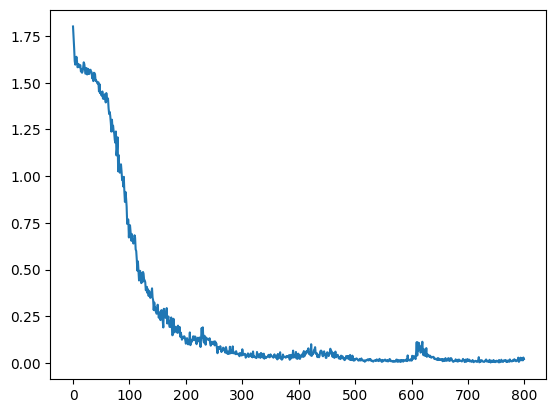

In [24]:
train(model, dataset['train'], optimizer, criterion, BATCH_SIZE, EPOCHS)

In [25]:
train_f1 = test(model, dataset['train'])
val_f1 = test(model, dataset['validation'])
test_f1 = test(model, dataset['test'])

print(f"Train F1: {train_f1}, Validation F1: {val_f1}, Test F1: {test_f1}")

Train F1: 0.9958750649610838, Validation F1: 0.8764460647095261, Test F1: 0.8685661807729537


In [26]:
## torch.save(model.state_dict(), "emotion_classifier.pth")

import datetime
# Save the model
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
model_path = f"emotion_classifier_{current_date}.pth"
torch.save(model.state_dict(), model_path)

# Classifying Emotions

In [27]:
emotions= {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

current_date = datetime.datetime.now().strftime("%Y-%m-%d")
model_path = f"emotion_classifier_{current_date}.pth"

model = Classifier(vocab_size = vocab_size, embed_dim = EMBD_DIM, hidden_dim = HIDDEN_DIM, output_dim = OUTPUT_DIM)
model.load_state_dict(torch.load(model_path))

def predict_emotion(model, text):
    text = [token_idx_map[token] if token in token_idx_map else token_idx_map["<unk>"] for token in re.findall(compiled_pat, text)]
    text = torch.tensor(text).unsqueeze(0)
    output = model(text)
    output = F.softmax(output, dim=1)
    output = torch.argmax(output)
    return emotions[int(output)]

In [28]:
predict_emotion(model, "This is fun")

'joy'